In [1]:
import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

#specialty libraries 
import pyshtools

from regridding import ConservativeRegridder
import regridding
import graph_utils as gu

import os
import sys
import yaml
import numpy as np
from datetime import datetime, timedelta

# graph tools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as patches

import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

from dask.distributed import Client, get_client

from credit.data import get_forward_data
from glob import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join




from credit.xr_sampler import XRSamplerByYear
import yaml


#### debug option

In [2]:
# rollout_files = rollout_files[:2]

In [3]:
with open("/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train/model.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

sampler = XRSamplerByYear("/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train/model.yml")

def get_data(rollout_files, variables, level):
    def select_darray(ds_given):
        ds_sel = ds_given[variables]
        return ds_sel.isel(level=level)
    
    
    # get pred and true data
    pred_da_list = []
    true_da_list = []
    for file in rollout_files:
        ds = xr.open_dataset(file)
        da = select_darray(ds)
        pred_da_list.append(da)
        
    
    da_pred = xr.concat(pred_da_list, dim='time')
    return da_pred

In [15]:
variables, level = ["U", "V", "T"], 20

# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_diss_train"
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/prescribed_skebs_feb_14/1979-01-01T00Z"

## define metrics

In [ ]:
def pressure_to_height(pressure):
    """
    Convert atmospheric pressure (in hPa) to approximate height (in meters).

    This function uses a simplified version of the barometric formula to estimate
    the altitude based on atmospheric pressure under the assumption of a standard
    atmosphere.

    Parameters:
    ----------
    pressure : float
        Atmospheric pressure at the desired altitude (in hPa).

    Returns:
    -------
    float
        Approximate altitude (in meters) corresponding to the given pressure.

    Formula:
    --------
    h = 44330 * (1 - (P / P0) ** (1 / 5.255))
    
    Where:
    - h: Altitude in meters.
    - P: Pressure at the current altitude (in hPa).
    - P0: Standard sea level pressure (1013.25 hPa).
    - 44330: Constant derived from standard atmosphere assumptions.
    - 5.255: Exponent related to the pressure-altitude relationship.

    Assumptions:
    ------------
    - Assumes a standard atmosphere with:
        - Sea level pressure of 1013.25 hPa.
        - Temperature decreases linearly with altitude at 6.5 K/km.
        - Constant composition of air.
    - Ignores humidity and local atmospheric deviations.

    Usage:
    ------
    - Commonly used in meteorology, aviation, and environmental sciences to 
      approximate altitude from pressure sensor readings.

    Example:
    --------
    >>> pressure_to_height(900)
    1101.843525337259  # Approximate altitude in meters at 900 hPa
    """
    return 44330 * (1 - (pressure / 1013.25) ** (1 / 5.255))


def zonal_energy_spectrum_sph(ds_input: xr.Dataset, 
                              varname: str,
                              grid_type: str ='DH',
                              rescale=False)-> xr.DataArray:
    '''
    Computes the Zonal Energy Spectrum of a variable in an xarray.Dataset 
    using spherical harmonic transform. The output is rescaled by the 
    mean circumference per longitude grid.
    
    Parameters:
    - ds_input: xarray.Dataset containing the data.
    - varname: Name of the variable to compute the spectrum for.
    - grid_type: 'GLQ' or 'DH'
    - rescale: produce m * unit result based on circumference

    Returns:
    - spectrum: xarray.DataArray containing the zonal energy spectrum.
    '''
    RAD_EARTH = 6371000
    
    data = ds_input[varname]

    # check 'latitude' and 'longitude' cooridnate names
    if 'latitude' not in data.dims or 'longitude' not in data.dims:
        raise ValueError("Data must have 'latitude' and 'longitude' dimensions")
        
    latitudes = data['latitude'].values
    longitudes = data['longitude'].values

    # check latitudes for [90, -90] descending order
    # if not flip data and latitude
    if latitudes[0] < latitudes[-1]:
        data = data.isel(latitude=slice(None, None, -1))
        latitudes = data['latitude'].values
        
    # check longitudes for [0, 360] order
    # if not re-organize
    if np.any(longitudes < 0):
        longitudes = (longitudes + 360) % 360
        sorted_indices = np.argsort(longitudes)
        data = data.isel(longitude=sorted_indices)
        longitudes = data['longitude'].values

    # number of grids
    nlat = len(latitudes)
    nlon = len(longitudes)
    
    # max wavenumber is half of the latitude grids -1
    max_wavenum = (nlat - 1) // 2  # int divide
    
    # allocate zonal wavenumbers ranges
    zonal_wavenumbers = np.arange(max_wavenum + 1)

    def compute_power_m(data_array_2d):
        '''
        Computes the power spectrum for a 2D data array using spherical harmonics.

        Parameters:
        - data_array_2d: 2D numpy array of shape (nlat, nlon)

        Returns:
        - power_m: 1D numpy array of power corresponding to each zonal wavenumber m
        '''
        # initialize SHGrid
        grid = pyshtools.SHGrid.from_array(data_array_2d, grid=grid_type)
        
        # expand the grid to spherical harmonic coefs
        coeffs = grid.expand(normalization='ortho', lmax_calc=max_wavenum)

        # power per degree per order. shape=(lmax+1, lmax+1)
        coeffs_squared = coeffs.coeffs[0]**2 + coeffs.coeffs[1]**2
        
        # allocate power array for each zonal wavenumber m
        power_m = np.zeros(max_wavenum + 1)
        
        # sum over degrees l > m for each order m to get the total power
        # -l < m < l
        for l in range(max_wavenum + 1):
            power_m[l] = np.sum(coeffs_squared[l:, l])
        
        return power_m

    # xr.apply_ufunc scope
    spectrum = xr.apply_ufunc(
        compute_power_m,
        data,
        input_core_dims=[['latitude', 'longitude']],
        output_core_dims=[['zonal_wavenumber']],
        vectorize=True,
        dask='parallelized',  # <-- dask parallelization
        output_dtypes=[float],
    )

    # assign new coordinate 'zonal_wavenumber'
    spectrum = spectrum.assign_coords(zonal_wavenumber=zonal_wavenumbers)

    if rescale:
        # re-scale power spectrum based on the mean circumference per longitude
        cos_latitudes = np.cos(np.deg2rad(latitudes))
        normalization_factor = (RAD_EARTH * np.sum(cos_latitudes)) / nlon
        
        spectrum = spectrum * normalization_factor
    
    return spectrum

In [ ]:
%%time
DSera5 = xr.open_dataset('/glade/derecho/scratch/dkimpara/CREDIT_runs/spat_grid.nc')

conc = []
verif_results = []

for yryr in range(2012,2013):
    
    path_verif = f'./zes_{yryr}'

    print(f'doing {yryr}')
    DSdo_1 = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
    # conc.append(DSdo_1)
    

    DScesm = DSdo_1[['T','U','V']].isel(level=20).load()
    DScesm['theta'] = DScesm['T'] * (1000/524.7)**(287.0/1004)
    
    source_grid = regridding.Grid.from_degrees(DScesm.longitude.values,DScesm.latitude.values)
    target_grid = regridding.Grid.from_degrees(DSera5.longitude.values,DSera5.latitude[::-1].values)
    REg = regridding.ConservativeRegridder(source_grid,target_grid)
    
    DA = REg.regrid_dataset(DScesm)
    DA = DA.assign_coords(latitude=DSera5.latitude[::-1].values)
    DA = DA.assign_coords(longitude=DSera5.longitude.values)
    DA = DA.transpose("time", "latitude", "longitude")
    zes_temp = []
    for var in ['U', 'V', 'theta']:
        zes = zonal_energy_spectrum_sph(DA, var, grid_type='GLQ')
        zes_temp.append(zes)
        
    verif_results.append(xr.merge(zes_temp))

ds_verif = xr.concat(verif_results, dim='time')
ds_verif['KE'] = 0.5*(ds_verif['V']+ds_verif['U'])
ds_verif_means = ds_verif.mean('time')

print('CAMulator') 
DSdt = xr.open_dataset('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z/datetimes_in_files.nc')
client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
verif_results_em = []

rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/archive_skebs/skebs_conv_train"
rollout_files = glob(join(rollout_dir, "201*Z/*.nc"))


DScesm = get_data(rollout_files, ["U", "V", "T"], 20)

DScesm['theta'] = DScesm['T'] * (1000/524.7)**(287.0/1004)

source_grid = regridding.Grid.from_degrees(DScesm.longitude.values,DScesm.latitude.values)
target_grid = regridding.Grid.from_degrees(DSera5.longitude.values,DSera5.latitude[::-1].values)
REg = regridding.ConservativeRegridder(source_grid,target_grid)

DA = REg.regrid_dataset(DScesm)
DA = DA.assign_coords(latitude=DSera5.latitude[::-1].values)
DA = DA.assign_coords(longitude=DSera5.longitude.values)
DA = DA.transpose("time", "latitude", "longitude")

zes_temp_em = []
for var in ['U', 'V', 'theta']:
    zes = zonal_energy_spectrum_sph(DA, var, grid_type='GLQ')
    zes_temp_em.append(zes)
    
verif_results_em.append(xr.merge(zes_temp_em))
    

ds_verif_em = xr.concat(verif_results_em, dim='time')
ds_verif_em['KE'] = 0.5*(ds_verif_em['V']+ds_verif_em['U'])
ds_verif_means_em = ds_verif_em.mean('time')

# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

# run metrics

In [17]:
import multiprocessing
from functools import partial

In [25]:
f = partial(spread_error, variable, level)
with multiprocessing.Pool(8) as p:
    
    result = p.map(f, range(6, 73, 6))

In [19]:
len(result)

12

In [20]:
# n/s extra tropics and tropics

In [26]:
n_std, n_error = [], []
t_std, t_error = [], []
s_std, s_error = [], []

for res in result:
    std, error = res
    # std, error = std.mean(dim="longitude"), error.mean(dim="longitude")
    # n extratropics
    n_std.append(std.sel(latitude=slice(24,91)).mean().values)
    n_error.append(error.sel(latitude=slice(24,91)).mean().values)
    # tropics
    t_std.append(std.sel(latitude=slice(-24,24)).mean().values)
    t_error.append(error.sel(latitude=slice(-24,24)).mean().values)
    # s extra tropics
    s_std.append(std.sel(latitude=slice(-91,-24)).mean().values)
    s_error.append(error.sel(latitude=slice(-91,-24)).mean().values)
    

In [27]:
forecast_day = 6 * (np.arange(len(result)) + 1) / 24
def plot(std, error, label=None):
    plt.plot(forecast_day, std, label="std", c='tab:orange')
    plt.plot(forecast_day, error, label="rmse", c='b')
    plt.xlabel("Day")
    plt.title(f"{variable}{level if variable in 'UVTQtot' else ''} {label} Spread-Error")
    plt.legend()
    plt.grid(True)
    plt.show()

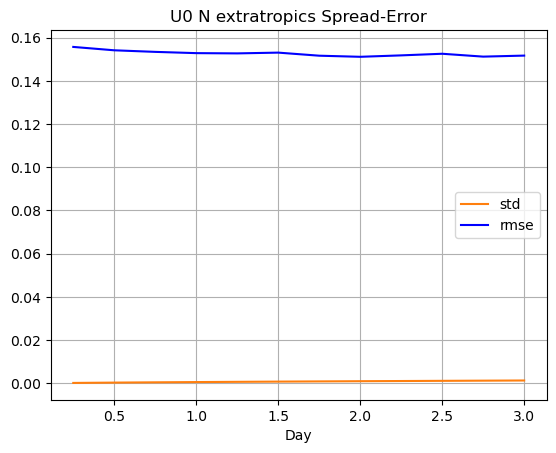

In [28]:
plot(n_std, n_error, "N extratropics")

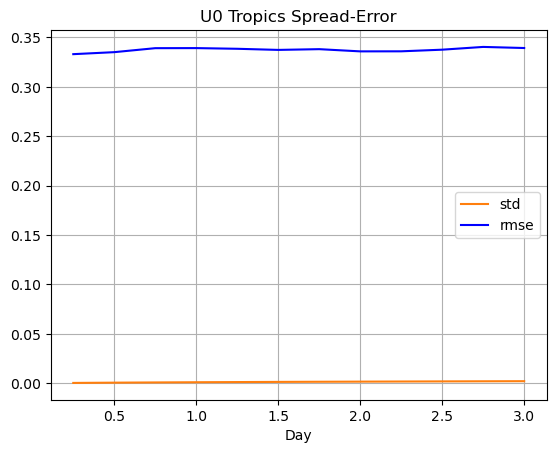

In [24]:
plot(t_std, t_error, "Tropics")

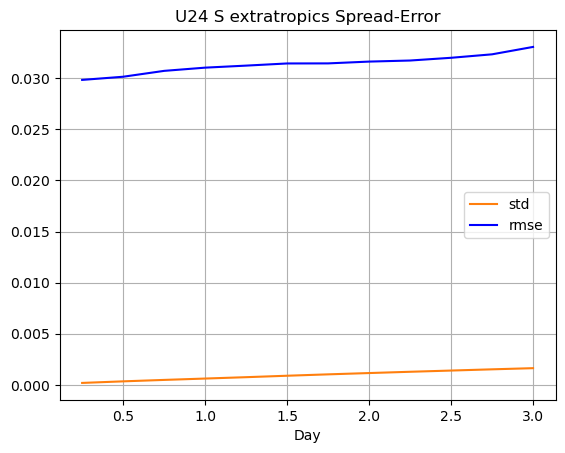

In [14]:
plot(s_std, s_error, "S extratropics")